In [1]:
import numpy as np
import pandas as pd
import river
import sys
from river import optim
from river import metrics
from river.drift import ADWIN
from ray.tune.search import BasicVariantGenerator
from sail.models.auto_ml.tune import SAILTuneGridSearchCV
from sail.models.river.forest import AdaptiveRandomForestClassifier
from sail.models.river.linear_model import LogisticRegression
from sail.models.auto_ml.auto_pipeline import SAILAutoPipeline
from sail.pipeline import SAILPipeline
from sklearn.impute import SimpleImputer
import ray.cloudpickle as cpickle
from sail.transfomers.river.preprocessing import StandardScaler

#### Load Data


In [2]:
df = pd.read_csv("../../datasets/agrawal.csv").head(50000)
X = df.copy()

y = X["class"]
X.drop("class", axis=1, inplace=True)


#### Model Definition


In [3]:
logistic_reg = LogisticRegression(optimizer=optim.SGD(0.1))
random_forest = AdaptiveRandomForestClassifier(n_models=10)

#### Create SAIL Pipeline


In [4]:
steps = [
    ("Imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
    ("standard_scalar", StandardScaler()),
    ("classifier", "passthrough"),
]
sail_pipeline = SAILPipeline(steps=steps)

[2023-06-25 22:17:10:837] - INFO - SAIL : created SAILPipeline object with ID 4a80d1a6-8eb0-45c7-aec2-05acc9e3596a


#### HPO Params


In [5]:
params_grid = [
    {
        "classifier": [logistic_reg],
        "classifier__l2": [0.1, 0.9],
        "classifier__intercept_init": [0.2, 0.5],
    },
    {
        "classifier": [random_forest],
        "classifier__n_models": [5, 10],
        "Imputer": ["passthrough"],
    },
]

# params_grid = {
#     "classifier__l2": [0.1, 0.9],
#     "classifier__intercept_init": [0.2, 0.5],
# }


#### Create Model Instance


In [6]:
auto_pipeline = SAILAutoPipeline(
    pipeline=sail_pipeline,
    pipeline_params_grid=params_grid,
    search_method=SAILTuneGridSearchCV,
    search_method_params={
        "max_iters": 1,
        "early_stopping": False,
        "mode": "max",
        "scoring": "accuracy",
        "pipeline_auto_early_stop": False,
        "keep_best_configurations": 2
    },
    search_data_size=1000,
    incremental_training=True,
    scoring=metrics.Accuracy,
    drift_detector=ADWIN(delta=0.001),
    pipeline_strategy="DetectAndIncrement",
)

[2023-06-25 22:17:10:846] - INFO - SAIL : Pipeline Strategy [DetectAndIncrement] created with actions: ['DATA_COLLECTION', 'FIND_BEST_PIPELINE', 'SCORE_AND_DETECT_DRIFT', 'PARTIAL_FIT_MODEL']


#### Start Training


In [7]:
y_preds = []
y_true = []
batch_size = 50

start = 0
for end in range(50, 2001, batch_size):

    X_train = X.iloc[start:end]
    y_train = y.iloc[start:end]

    if end > 1000: # search_data_size is 1000
        preds = auto_pipeline.predict(X_train)
        y_preds.extend(list(preds))
        y_true.extend(list(y_train))

    auto_pipeline.train(X_train, y_train, classifier__classes=[1, 0])
    start = end


(_Trainable pid=84403) [2023-06-25 22:17:16:211] - INFO - SAIL : created SAILPipeline object with ID 0b9e1f4f-e215-4f11-9aa9-0f45eea19754
(_Trainable pid=84403) [2023-06-25 22:17:16:211] - INFO - SAIL : created SAILPipeline object with ID eb02a64e-c71f-4cb4-a0a2-bafe6f5bb50e
(_Trainable pid=84403) [2023-06-25 22:17:16:211] - INFO - SAIL : created SAILPipeline object with ID 6663e8cc-4b98-45d6-bee0-08ac753214ff
(_Trainable pid=84403) [2023-06-25 22:17:16:211] - INFO - SAIL : created SAILPipeline object with ID d3f3aa0f-8f20-461e-8f72-11f495340b7e
(_Trainable pid=84403) [2023-06-25 22:17:16:212] - INFO - SAIL : created SAILPipeline object with ID 8a56de75-b597-4e86-a621-05dc194378e2
(_Trainable pid=84403) [2023-06-25 22:17:16:235] - INFO - SAIL : created SAILPipeline object with ID 51c7bac8-d9e2-409f-9130-02d8a1ccc00f
(_Trainable pid=84403) [2023-06-25 22:17:16:260] - INFO - SAIL : created SAILPipeline object with ID 95695f3b-eec9-412f-b75c-b878315f469b
2023-06-25 22:17:16,363	INFO tenso

(_Trainable pid=84402) [Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s


2023-06-25 22:17:17,931	INFO tensorboardx.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'classifier': AdaptiveRandomForestClassifier()}
2023-06-25 22:17:19,207	INFO tensorboardx.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'classifier': AdaptiveRandomForestClassifier()}
[2023-06-25 22:17:19:251] - INFO - SAIL : created SAILPipeline object with ID 024b47bd-c4d9-4ede-9717-61fa873c9fa3
[2023-06-25 22:17:19:252] - INFO - SAIL : created SAILPipeline object with ID a498075e-48d6-40c6-92a9-0d5f38c5eef0
[2023-06-25 22:17:20:16] - INFO - SAIL : Cumulative Pipeline Score: 0.88
[2023-06-25 22:17:20:16] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:20:16] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:20:79] - INFO - SAIL : Cumulative Pipeline Score: 0.9
[2023-06-25 22:17:20:79] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:20:80] - INFO - SAIL : Calling 

[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.7s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s


[2023-06-25 22:17:20:260] - INFO - SAIL : Cumulative Pipeline Score: 0.888
[2023-06-25 22:17:20:261] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:20:261] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:20:323] - INFO - SAIL : Cumulative Pipeline Score: 0.8833333333333333
[2023-06-25 22:17:20:324] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:20:324] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:20:384] - INFO - SAIL : Cumulative Pipeline Score: 0.8942857142857142
[2023-06-25 22:17:20:385] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:20:385] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:20:441] - INFO - SAIL : Cumulative Pipeline Score: 0.895
[2023-06-25 22:17:20:441] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:20:441] - INFO - SAIL : Calling Partial_fit() on the pipeline.


[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s


[2023-06-25 22:17:20:504] - INFO - SAIL : Cumulative Pipeline Score: 0.8933333333333333
[2023-06-25 22:17:20:505] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:20:505] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:20:569] - INFO - SAIL : Cumulative Pipeline Score: 0.886
[2023-06-25 22:17:20:569] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:20:570] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:20:630] - INFO - SAIL : Cumulative Pipeline Score: 0.889090909090909
[2023-06-25 22:17:20:630] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:20:630] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:20:688] - INFO - SAIL : Cumulative Pipeline Score: 0.8916666666666667
[2023-06-25 22:17:20:689] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:20:689] - INFO - SAIL : Calling Partial_fit() on the pipeline.


[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s


[2023-06-25 22:17:20:748] - INFO - SAIL : Cumulative Pipeline Score: 0.8923076923076924
[2023-06-25 22:17:20:749] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:20:749] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:20:807] - INFO - SAIL : Cumulative Pipeline Score: 0.8957142857142857
[2023-06-25 22:17:20:807] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:20:808] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:20:866] - INFO - SAIL : Cumulative Pipeline Score: 0.8973333333333333
[2023-06-25 22:17:20:866] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:20:866] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:20:927] - INFO - SAIL : Cumulative Pipeline Score: 0.89375
[2023-06-25 22:17:20:927] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:20:928] - INFO - SAIL : Calling Partial_fit() on the pipeline.


[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s


[2023-06-25 22:17:20:989] - INFO - SAIL : Cumulative Pipeline Score: 0.8929411764705882
[2023-06-25 22:17:20:990] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:20:990] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:21:51] - INFO - SAIL : Cumulative Pipeline Score: 0.8911111111111111
[2023-06-25 22:17:21:51] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:21:52] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:21:114] - INFO - SAIL : Cumulative Pipeline Score: 0.8905263157894737
[2023-06-25 22:17:21:114] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:21:114] - INFO - SAIL : Calling Partial_fit() on the pipeline.


[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s


[2023-06-25 22:17:21:178] - INFO - SAIL : Cumulative Pipeline Score: 0.889
[2023-06-25 22:17:21:178] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:21:178] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:21:246] - INFO - SAIL : Cumulative Pipeline Score: 0.8914285714285715
[2023-06-25 22:17:21:247] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:21:247] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:21:307] - INFO - SAIL : Cumulative Pipeline Score: 0.8927272727272727
[2023-06-25 22:17:21:308] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:21:308] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:21:367] - INFO - SAIL : Cumulative Pipeline Score: 0.8921739130434783
[2023-06-25 22:17:21:368] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:21:368] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:21:427] - INFO - SA

[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.1s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s


[2023-06-25 22:17:21:483] - INFO - SAIL : Cumulative Pipeline Score: 0.8912
[2023-06-25 22:17:21:483] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:21:483] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:21:542] - INFO - SAIL : Cumulative Pipeline Score: 0.8892307692307693
[2023-06-25 22:17:21:543] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:21:543] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:21:601] - INFO - SAIL : Cumulative Pipeline Score: 0.8888888888888888
[2023-06-25 22:17:21:602] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:21:602] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:21:665] - INFO - SAIL : Cumulative Pipeline Score: 0.8871428571428571
[2023-06-25 22:17:21:665] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:21:666] - INFO - SAIL : Calling Partial_fit() on the pipeline.


[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s


[2023-06-25 22:17:21:725] - INFO - SAIL : Cumulative Pipeline Score: 0.883448275862069
[2023-06-25 22:17:21:725] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:21:725] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:21:791] - INFO - SAIL : Cumulative Pipeline Score: 0.8813333333333333
[2023-06-25 22:17:21:792] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:21:792] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:21:850] - INFO - SAIL : Cumulative Pipeline Score: 0.8825806451612903
[2023-06-25 22:17:21:850] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:21:850] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:21:911] - INFO - SAIL : Cumulative Pipeline Score: 0.88
[2023-06-25 22:17:21:911] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:21:912] - INFO - SAIL : Calling Partial_fit() on the pipeline.


[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s


[2023-06-25 22:17:21:977] - INFO - SAIL : Cumulative Pipeline Score: 0.8787878787878788
[2023-06-25 22:17:21:977] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:21:978] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:22:35] - INFO - SAIL : Cumulative Pipeline Score: 0.8794117647058823
[2023-06-25 22:17:22:35] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:22:35] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:22:97] - INFO - SAIL : Cumulative Pipeline Score: 0.8794285714285714
[2023-06-25 22:17:22:97] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:22:97] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:22:159] - INFO - SAIL : Cumulative Pipeline Score: 0.8794444444444445
[2023-06-25 22:17:22:159] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:22:160] - INFO - SAIL : Calling Partial_fit() on the pipeline.


[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s


[2023-06-25 22:17:22:226] - INFO - SAIL : Cumulative Pipeline Score: 0.8805405405405405
[2023-06-25 22:17:22:227] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:22:227] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:22:288] - INFO - SAIL : Cumulative Pipeline Score: 0.881578947368421
[2023-06-25 22:17:22:289] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:22:289] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:22:349] - INFO - SAIL : Cumulative Pipeline Score: 0.882051282051282
[2023-06-25 22:17:22:350] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:22:351] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:22:419] - INFO - SAIL : Cumulative Pipeline Score: 0.8795
[2023-06-25 22:17:22:419] - INFO - SAIL : Partially fitting best pipeline.


[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s


[2023-06-25 22:17:22:419] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:22:481] - INFO - SAIL : Cumulative Pipeline Score: 0.88
[2023-06-25 22:17:22:482] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:22:482] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:22:545] - INFO - SAIL : Cumulative Pipeline Score: 0.8819047619047619
[2023-06-25 22:17:22:545] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:22:546] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:22:606] - INFO - SAIL : Cumulative Pipeline Score: 0.8809302325581395
[2023-06-25 22:17:22:606] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:22:607] - INFO - SAIL : Calling Partial_fit() on the pipeline.


[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s


[2023-06-25 22:17:22:667] - INFO - SAIL : Cumulative Pipeline Score: 0.8804545454545455
[2023-06-25 22:17:22:668] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:22:668] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:22:727] - INFO - SAIL : Cumulative Pipeline Score: 0.8808888888888889
[2023-06-25 22:17:22:728] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:22:728] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:22:788] - INFO - SAIL : Cumulative Pipeline Score: 0.8804347826086957
[2023-06-25 22:17:22:788] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:22:789] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:22:851] - INFO - SAIL : Cumulative Pipeline Score: 0.8817021276595745
[2023-06-25 22:17:22:851] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:22:851] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:22:912

[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s


[2023-06-25 22:17:22:972] - INFO - SAIL : Cumulative Pipeline Score: 0.883265306122449
[2023-06-25 22:17:22:973] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:22:973] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:23:35] - INFO - SAIL : Cumulative Pipeline Score: 0.8828
[2023-06-25 22:17:23:35] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:23:35] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:23:96] - INFO - SAIL : Cumulative Pipeline Score: 0.884313725490196
[2023-06-25 22:17:23:97] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:23:97] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:23:156] - INFO - SAIL : Cumulative Pipeline Score: 0.8838461538461538
[2023-06-25 22:17:23:156] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:23:156] - INFO - SAIL : Calling Partial_fit() on the pipeline.


[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s


[2023-06-25 22:17:23:220] - INFO - SAIL : Cumulative Pipeline Score: 0.8852830188679245
[2023-06-25 22:17:23:221] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:23:221] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:23:284] - INFO - SAIL : Cumulative Pipeline Score: 0.8866666666666667
[2023-06-25 22:17:23:285] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:23:285] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:23:346] - INFO - SAIL : Cumulative Pipeline Score: 0.8858181818181818
[2023-06-25 22:17:23:346] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:23:346] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:23:410] - INFO - SAIL : Cumulative Pipeline Score: 0.8875
[2023-06-25 22:17:23:410] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:23:411] - INFO - SAIL : Calling Partial_fit() on the pipeline.


[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s


[2023-06-25 22:17:23:474] - INFO - SAIL : Cumulative Pipeline Score: 0.8880701754385965
[2023-06-25 22:17:23:474] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:23:474] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:23:535] - INFO - SAIL : Cumulative Pipeline Score: 0.8896551724137931
[2023-06-25 22:17:23:535] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:23:536] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:23:601] - INFO - SAIL : Cumulative Pipeline Score: 0.8915254237288136
[2023-06-25 22:17:23:601] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:23:601] - INFO - SAIL : Calling Partial_fit() on the pipeline.


[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.1s


[2023-06-25 22:17:23:673] - INFO - SAIL : Cumulative Pipeline Score: 0.8916666666666667
[2023-06-25 22:17:23:674] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:23:674] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:23:739] - INFO - SAIL : Cumulative Pipeline Score: 0.8904918032786885
[2023-06-25 22:17:23:739] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:23:739] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:23:806] - INFO - SAIL : Cumulative Pipeline Score: 0.8916129032258064
[2023-06-25 22:17:23:806] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:23:806] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:23:868] - INFO - SAIL : Cumulative Pipeline Score: 0.8926984126984127
[2023-06-25 22:17:23:868] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:23:869] - INFO - SAIL : Calling Partial_fit() on the pipeline.


[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s


[2023-06-25 22:17:23:935] - INFO - SAIL : Cumulative Pipeline Score: 0.89375
[2023-06-25 22:17:23:936] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:23:936] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:23:999] - INFO - SAIL : Cumulative Pipeline Score: 0.8941538461538462
[2023-06-25 22:17:23:999] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:23:999] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:24:59] - INFO - SAIL : Cumulative Pipeline Score: 0.8948484848484849
[2023-06-25 22:17:24:60] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:24:60] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:24:124] - INFO - SAIL : Cumulative Pipeline Score: 0.8946268656716417
[2023-06-25 22:17:24:124] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:24:124] - INFO - SAIL : Calling Partial_fit() on the pipeline.


[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s


[2023-06-25 22:17:24:189] - INFO - SAIL : Cumulative Pipeline Score: 0.8958823529411765
[2023-06-25 22:17:24:190] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:24:190] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:24:259] - INFO - SAIL : Cumulative Pipeline Score: 0.8965217391304348
[2023-06-25 22:17:24:259] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:24:259] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:24:321] - INFO - SAIL : Cumulative Pipeline Score: 0.896
[2023-06-25 22:17:24:322] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:24:322] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:24:387] - INFO - SAIL : Cumulative Pipeline Score: 0.896056338028169
[2023-06-25 22:17:24:388] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:24:388] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:24:455] - INFO - SAI

[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.1s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.1s


[2023-06-25 22:17:24:528] - INFO - SAIL : Cumulative Pipeline Score: 0.8975342465753424
[2023-06-25 22:17:24:528] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:24:529] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:24:599] - INFO - SAIL : Cumulative Pipeline Score: 0.8978378378378379
[2023-06-25 22:17:24:600] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:24:600] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:24:670] - INFO - SAIL : Cumulative Pipeline Score: 0.8986666666666666
[2023-06-25 22:17:24:671] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:24:671] - INFO - SAIL : Calling Partial_fit() on the pipeline.


[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.1s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.1s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.1s


[2023-06-25 22:17:24:740] - INFO - SAIL : Cumulative Pipeline Score: 0.8989473684210526
[2023-06-25 22:17:24:740] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:24:741] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:24:812] - INFO - SAIL : Cumulative Pipeline Score: 0.8992207792207793
[2023-06-25 22:17:24:812] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:24:812] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:24:881] - INFO - SAIL : Cumulative Pipeline Score: 0.8994871794871795
[2023-06-25 22:17:24:881] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:24:882] - INFO - SAIL : Calling Partial_fit() on the pipeline.


[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.1s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.1s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.1s


[2023-06-25 22:17:24:954] - INFO - SAIL : Cumulative Pipeline Score: 0.900506329113924
[2023-06-25 22:17:24:954] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:24:954] - INFO - SAIL : Calling Partial_fit() on the pipeline.
[2023-06-25 22:17:25:24] - INFO - SAIL : Cumulative Pipeline Score: 0.90125
[2023-06-25 22:17:25:24] - INFO - SAIL : Partially fitting best pipeline.
[2023-06-25 22:17:25:25] - INFO - SAIL : Calling Partial_fit() on the pipeline.


[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.1s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.1s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.1s


In [8]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2674
           1       0.90      0.85      0.87      1326

    accuracy                           0.92      4000
   macro avg       0.91      0.90      0.91      4000
weighted avg       0.92      0.92      0.92      4000



<Axes: >

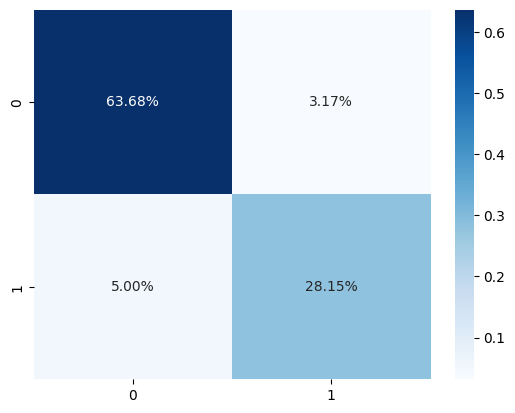

In [9]:
import seaborn as sns

cf_matrix = confusion_matrix(y_true, y_preds)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')